# Poisson equation in 1D

In this example, we show how to solve the Poisson equation in 1D

$$ - \frac{\partial^2 u}{\partial^2 x} = f(x)  \quad \forall x \in (0,1), $$

using the finite element method different types of boundary conditions.

## Homogeneus Dirichlet boundary conditions

Consider

$$ - \frac{\partial^2 u}{\partial^2 x} = f(x)  \quad \forall x \in (0,1), $$

with homegeneuos Dirichlet boundary conditions $u(0) = u(1) = 0$.

To obtain the weak form, we let $\Omega = (0,1)$ and we define the functional space $V = H^1_0(\Omega) := \{ v \in L^2(\Omega) | v_x \in L^2(\Omega) \text{ and } v = 0 \text{ on } \partial \Omega\}$.

Then we multiply the strong form by an arbitrary function $v \in V$ and integrate over $\Omega$:

$$ - \int_0^1 \frac{\partial^2 u}{\partial^2 x} v \, dx = \int_0^1 f\,v \, dx, \quad \forall v \in V $$

Integration by parts of the non-conforming term gives

$$ - \int_0^1 \frac{\partial^2 u}{\partial^2 x} v \, dx = \int_0^1 \frac{\partial u}{\partial x} \frac{\partial v}{\partial x} \, dx - \left( \left.\frac{\partial u}{\partial x}\right|_{x=1}\, v(1) - \left.\frac{\partial u}{\partial x}\right|_{x=0}\,v(0) \right). $$

Recalling that $v(1) = v(0) = 0$ because of the Dirichlet boundary conditions, we finally write

$$ \int_0^1 \frac{\partial u}{\partial x} \frac{\partial v}{\partial x} \, dx = \int_0^1 f\,v \, dx, \quad \forall v \in V. $$

To obtain the finite element discretization we then consider a finite dimensional subspace $V_h \subset V$ and we find $u_h \in V_h$ such that

$$ \int_0^1 \frac{\partial u_h}{\partial x} \frac{\partial v_h}{\partial x} \, dx = \int_0^1 f\,v_h \, dx, \quad \forall v_h \in V_h. $$

Below we solve the problem using FEniCS for the choice $f(x) = \sin(\pi x)$. The analytical solution is $u_{ex} = \frac{1}{\pi^2} \sin(\pi x)$.

### 1. Imports
We import the following Python packages:

- `dolfinx` is the python interface to FEniCSx.
- `ufl` is the python interface used to define variational forms in FEniCSx
- `matplotlib` is a plotting library that produces figure similar to the Matlab ones.
- `numpy` is a python built-in library with many mathematical functions.

In [2]:
# Import FEniCSx
import dolfinx as dl
import ufl

from mpi4py import MPI
from petsc4py import PETSc

# Import the package of mathematical functions
import math
import numpy as np

# Enable plotting inside the notebook
import matplotlib.pyplot as plt
import pyvista as pv
pv.set_jupyter_backend('static')

### 2. Define the mesh and the finite element space
We define a mesh of the domain $(0,1)$ with `nx` elements and `nx+1` vertices. The mesh size $h$ is $\frac{1}{n_{x}}$.
`create_unit_interval` is a `dolfinx` class (function?) that create a mesh for the unit interval. It takes as input the number of elements $nx$ and an MPI communicator.

We also define the finite element space $V_h$ as the space of globally continuos functions that are piecewise linear  on the elements of the mesh. The number of degrees of freedom (dofs) of the space $V_h$ is $n+1$ (i.e. equal to the number of vertices in the mesh).
`FunctionSpace` is a `dolfinx.fem` class that constructs the finite element space. It takes as inputs the mesh, the type of finite element (`CG` stands for *Continuous Galerkin* elements), and the finite element order (in our case $1$, since we are using linear finite elements).

0 1


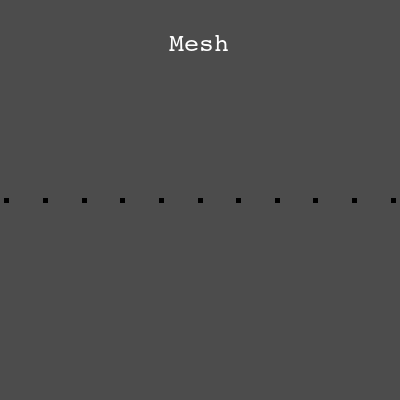

Number of dofs 11


In [11]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nprocs = comm.Get_size()
iAmRoot = rank == 0

# Define the finite element mesh. The mesh size h is 1/nx
nx = 10

    
mesh = dl.mesh.create_unit_interval(nx = nx, comm=MPI.COMM_WORLD)

# data for plotting
cells, types, coords = dl.plot.create_vtk_mesh(mesh, mesh.topology.dim)
grid = pv.UnstructuredGrid(cells, types, coords)

# Create plotter
window_size=[400,400]
plotter = pv.Plotter(window_size=window_size)
plotter.add_mesh(grid, style='points', color="k")
plotter.view_xz()
plotter.add_title('Mesh', font='courier', color='w',
                   font_size=10)
plotter.show()

# Define the finite element space V_h as the space of piecewise linear functions on the elements of the mesh.
degree = 1
Vh = dl.fem.FunctionSpace(mesh, ("CG", degree))
Vhp = dl.fem.FunctionSpace(mesh, ("CG", degree+2))
u  = dl.fem.Function(Vh)

print("Number of dofs", u.vector.size)

### 3. Define the right hand side f
We define the right hand side of the PDE using the `dolfinx.fem` class `Function` and its member function `interpolate`. The `interpolate` method takes as input mathematical definition of the expression, as a `lambda` function Here `x[0]` denotes the x coordinate of the mesh. In 2D, `x[1]` denotes the y coordinate of the mesh.

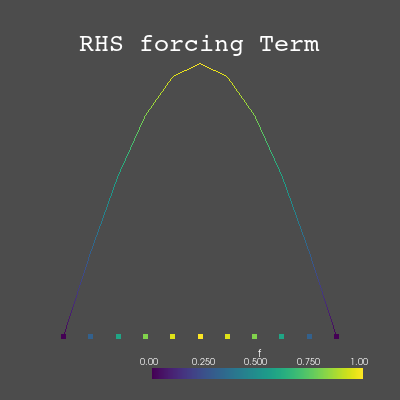

In [3]:
omega = np.pi
f = dl.fem.Function(Vh)

f.interpolate(lambda x: np.sin(omega * x[0]))
grid.point_data["f"] = f.x.array.real

plotter = pv.Plotter(window_size=window_size)
plotter.add_mesh(grid, style="points")
warped = grid.warp_by_scalar()

plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True, scalars="f")
plotter.view_xz()
plotter.add_title('RHS forcing Term', font='courier', color='w',
                     font_size=10)

plotter.show()

### 4. Define the Dirichlet boundary condition
We define the Dirichlet boundary condition on the $u(0) = u(1) = 0$.
The class `ScalarType` is used when we need to represent a value that is *constant* in space. As input it takes the value of the constant.
`dirichletbc` is the `dolfinx.fem` class that is used to describe Dirichlet boundary conditions. It takes three inputs: the function or value of the Dirichlet boundary condition `u_bc`, the finite element degrees of freedom `dofs` which are prescribed by the Dirichlet conditions, and the finite element space $V_h$.

In [4]:
u_bc = PETSc.ScalarType(0.)
facet_dim = mesh.topology.dim-1
facets = dl.mesh.locate_entities_boundary(mesh, dim=facet_dim, \
                                        marker=lambda x: 
                                        np.logical_or(np.isclose(x[0], 0.0), np.isclose(x[0], 1.0)))
dofs = dl.fem.locate_dofs_topological(V=Vh, entity_dim=facet_dim, entities=facets)
bcs = [dl.fem.dirichletbc(value=u_bc, dofs=dofs, V = Vh)]

### 5. Define the weak form
We now write the weak form of the Poisson equation:

- `uh`, the *trial* function, is an instance of the `ufl` class `TrialFunction`
- `vh`, the *test* function, is an instance of the `ufl` class `TestFunction`
- `grad` is the gradient operator acting on either a trial or test function. (In 1D $\operatorname{grad} := \frac{d}{dx}$).
- `inner` is the product of two scalar, vector, or tensor functions
- `dx` denotes that the integration is performed on the whole domain. `ds` (see next example) denotes that the integration is on the boundary of the domain.

**Note**: the `TrialFunction` and `TestFunction` are special objects used to represent a weak form. `uh` does **not** contains the vector of interpolation weights of the solution.


In [5]:
# Define the trial function uh and the test function vh
uh = ufl.TrialFunction(Vh)
vh = ufl.TestFunction(Vh)

A_expr = ufl.inner(ufl.grad(uh), ufl.grad(vh)) * ufl.dx
b_expr = f * vh * ufl.dx

### 6. Assemble and solve the finite element discrete problem
We now assemble the finite element stiffness matrix $A$ and the right hand side vector $b$ using the `petsc` `LinearProblem` class. `LinearProblem` takes the following inputs: the bilinear form `A_expr`, the linear form `b_expr`, `petsc_options` to specify the linear solver options and optionally a list of Dirichlet boundary conditions `bcs` and where to store the soltion `u`. We then call the `solve` method to solve the linear system $Au = b$.

The finite element function `u = dl.fem.Function(Vh)` represents the solution of the PDE. The interpolation weights are stored in `u.vector`.

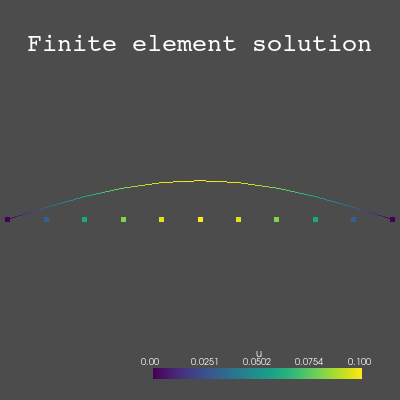

In [6]:
problem = dl.fem.petsc.LinearProblem(A_expr, b_expr, u=u, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
problem.solve()

grid.point_data["u"] = u.x.array.real

plotter = pv.Plotter(window_size=window_size)
plotter.add_mesh(grid, style="points")
warped = grid.warp_by_scalar()
plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True, scalars="u")
plotter.view_xz()
plotter.add_title('Finite element solution', font='courier', color='w',
                     font_size=10)
plotter.show()

### 7. Compute error norms
We then compute the error as measured in the $L^2(\Omega)$ and energy norms.

We use the `dolfinx.fem` function `assemble_scalar` to integrate $|u_h - u_{ex}|^2$ and $\left|\frac{d u_h}{dx} - \frac{d u_{ex}}{dx}\right|^2$
over the domain $\Omega$.

In [7]:
u_ex = dl.fem.Function(Vhp)
u_ex.interpolate(lambda x: (1. / omega**2) * np.sin(omega * x[0]))

loc_err_L2 = dl.fem.assemble_scalar(dl.fem.form((u_ex-u)**2 * ufl.dx))
err_L2  = np.sqrt(mesh.comm.allreduce(loc_err_L2, op=MPI.SUM))

loc_err_energy = dl.fem.assemble_scalar(dl.fem.form(ufl.inner(ufl.grad(u) - ufl.grad(u_ex), ufl.grad(u) - ufl.grad(u_ex)) * ufl.dx))
err_energy = np.sqrt(mesh.comm.allreduce(loc_err_energy, op=MPI.SUM))

if iAmRoot:
    print("|| u_h - u_ex ||_L^2 = {0:5e}".format(err_L2) )
    print( "|| u_h - u_ex ||_e = {0:5e}".format(err_energy) )

|| u_h - u_ex ||_L^2 = 1.197875e-03
|| u_h - u_ex ||_e = 2.046127e-02
